In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm

In [2]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

value_to_predict = 'Sex'
# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"
organ = "BRAIN0"

In [3]:

# fname = next((fdir_external / "HEART" / 'reg').glob("*processed.h5"))
# fname = fname.name

# data = pd.read_hdf(fdir_external / "HEART" / 'reg' / fname, index_col=0)
# data_header = pd.read_csv(fdir_external / "HEART" / 'reg' / 'SraRunTable.txt', sep=',')
# data_header.set_index('Run', inplace=True)


data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="data")
data_header = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="header")
# data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="geuvadis")
# data


In [4]:
data = data.iloc[:, np.argwhere(np.sum(data > 0, axis=0) > 18).ravel()]
data

,ENST00000003912.7,ENST00000004103.8,ENST00000012134.7,ENST00000013034.3,ENST00000019019.6,ENST00000038176.8,ENST00000055682.12,ENST00000070846.11,ENST00000075322.11,ENST00000075430.11,...,MSTRG.9920.1,MSTRG.9925.19,MSTRG.9929.7,MSTRG.994.2,MSTRG.9947.1,MSTRG.9948.7,MSTRG.9968.1,MSTRG.9981.2,MSTRG.9997.1,MSTRG.9997.4
SRR6918690,0.187807,1.193499,2.851731,0.416469,0.102197,2.884991,0.831195,0.000000,0.000000,0.000000,...,0.678769,1.555863,0.162431,0.000000,0.000000,0.040375,0.000000,5.399508,0.000000,0.589204
SRR6918691,0.250252,0.283825,2.137904,0.478539,0.954970,0.449383,0.000000,0.169607,2.163369,2.014407,...,0.000000,1.750823,0.688695,0.000000,0.648328,0.013702,0.000000,2.486963,0.000000,0.101011
SRR6918692,0.110279,0.000000,0.000000,0.538103,0.773081,0.000000,1.603205,0.000000,0.000000,0.000000,...,1.212419,0.279232,0.000000,0.000000,0.664579,0.887460,2.647153,0.347567,0.000000,0.446406
SRR6918693,0.024816,0.000000,3.273299,0.413249,0.429427,0.154429,0.000000,0.000000,1.148968,3.010112,...,0.000000,0.044652,0.000000,0.000000,0.854928,0.036278,0.000000,0.000000,1.755842,0.247556
SRR6918694,3.813127,1.297158,2.111182,0.415972,3.378956,1.185372,2.235456,0.572658,1.403590,0.000000,...,2.476784,0.000000,0.895691,0.995938,0.719679,0.612892,0.060865,5.500939,3.838310,0.144952
SRR6918695,1.428751,0.000000,3.399005,0.255941,1.263975,3.306380,0.000000,0.000000,0.000000,0.000000,...,0.307467,0.000000,2.219336,1.203706,0.000000,1.119986,0.169842,0.281153,0.650173,0.286207
SRR6918696,0.745363,0.000000,3.861111,0.000000,1.600997,2.966139,2.428609,0.886021,0.000000,0.000000,...,0.379786,1.322032,0.000000,0.000000,0.000000,1.465521,0.114335,0.187569,2.439044,0.140843
SRR6918697,0.068434,1.716192,2.644224,0.486317,0.000000,2.952591,0.000000,0.000000,2.938592,0.000000,...,0.266303,0.072394,0.261011,0.000000,0.000000,0.909331,0.000000,0.121949,0.535936,0.343848
SRR6918698,0.022113,1.472917,2.463228,0.365207,2.731516,2.602868,1.630597,0.779205,0.000000,0.331539,...,1.136432,1.986464,0.000000,1.062918,0.000000,0.000000,0.000000,6.145000,0.000000,0.295786
SRR6918699,0.114837,1.128930,0.000000,0.000000,0.000000,0.000000,2.061169,0.770592,0.000000,0.183188,...,0.572612,0.560710,0.000000,0.000000,1.040980,1.038566,0.000000,5.431961,0.000000,0.461092


In [5]:
# y = data_header[value_to_predict]
# X = data.values

sex = 'male'
sex = 'female'

y = data_header.loc[data_header['sex'] == sex][value_to_predict]
X = data.loc[data_header['sex'] == sex].values

X = RobustScaler().fit_transform(X)
# # X = StandardScaler().fit_transform(X)

In [6]:
from scipy.stats import spearmanr

rhos = []
pvalues = []

for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)


 75%|███████▌  | 9435/12578 [00:05<00:01, 1604.00it/s]/tmp/ipykernel_98311/2236386798.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(X[:, i], y)
100%|██████████| 12578/12578 [00:07<00:00, 1590.38it/s]


In [7]:
# np.argwhere(np.array(pvalues) < 0.05).shape
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)
# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0




In [8]:
corr_threshold = 0.96
corr_threshold = 0.5

if np.abs(rhos).max() > corr_threshold:
    sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
    sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
    # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
else:
    sorted_corr_ids = []

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

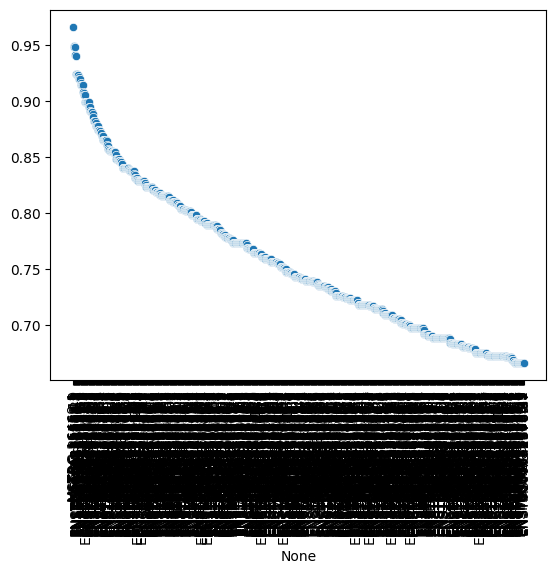

In [9]:
# plt.figure(figsize=(16,6))
sns.scatterplot(
    y=np.abs(rhos[sorted_corr_ids]), 
    x=data.columns[sorted_corr_ids],
    )
plt.xticks(rotation=90)

In [10]:
data.columns[sorted_corr_ids], len(sorted_corr_ids) 

(Index(['MSTRG.16469.1', 'MSTRG.8555.10', 'MSTRG.1517.15', 'MSTRG.31819.2',
        'MSTRG.25577.29', 'ENST00000514888.5', 'ENST00000614366.1',
        'ENST00000578173.5', 'ENST00000464236.1', 'ENST00000372103.1',
        ...
        'MSTRG.14714.10', 'MSTRG.11177.10', 'MSTRG.35223.29',
        'ENST00000516886.1', 'ENST00000369236.5', 'MSTRG.4433.1',
        'ENST00000423076.1', 'MSTRG.26158.15', 'ENST00000328705.7',
        'MSTRG.2578.37'],
       dtype='object', length=842),
 842)

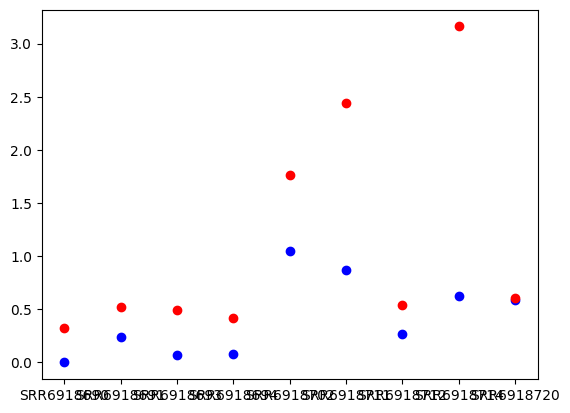

In [11]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [12]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]]

SRR6918690    0.000000
SRR6918691    0.238954
SRR6918693    0.066850
SRR6918694    0.078853
SRR6918702    1.047373
SRR6918711    0.868107
SRR6918712    0.264136
SRR6918714    0.629156
SRR6918720    0.585642
Name: MSTRG.16469.1, dtype: float32

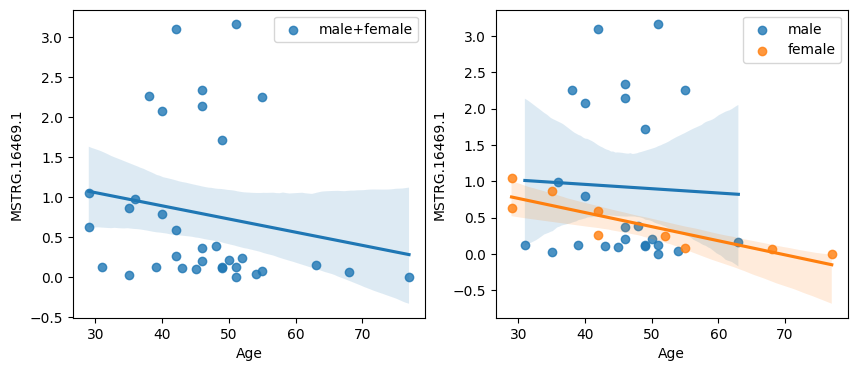

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

(9, 5)


9it [00:00, 432.34it/s]

26.298501304147038
26.298495022883255
Index(['MSTRG.16469.1', 'MSTRG.8555.10', 'MSTRG.1517.15', 'MSTRG.31819.2',
       'MSTRG.25577.29'],
      dtype='object')
[-18.451635    8.996166  -32.794174    0.7393923 -12.997597 ]
47.977905


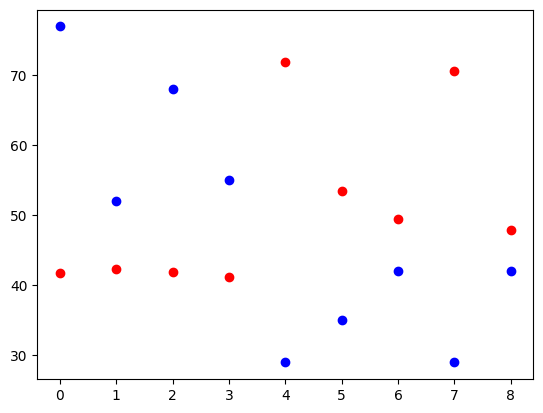

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn import svm
from xgboost import XGBRegressor


from sklearn.metrics import root_mean_squared_error as RMSE

n_features = 5

# sex = 'male'

X = data.loc[data_header['sex'] == sex, data.columns[sorted_corr_ids[:n_features]]].values
y = data_header['Age'].loc[data_header['sex'] == sex].values

print(X.shape)

# cv = StratifiedKFold(n_splits=5)
cv = LeaveOneOut()

preds = []
vals  = []
gls_preds = []

for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
    X_train = X[train]
    y_train = y[train]
    X_test = X[val]
    y_test = y[val]

    train_scaler = RobustScaler().fit(X_train)
    test_scaler = RobustScaler().fit(X_test)
    X_train = train_scaler.transform(X_train)
    X_test = test_scaler.transform(X_test)

    X_train_ = X_train
    y_train_ = y_train
    X_val = X_test
    y_val = y_test

    # model = svm.SVR(kernel='linear')
    model = LinearRegression()
    # model = XGBRegressor()
    # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
    #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
    
    model.fit(X_train_, y_train_)
    pred = model.predict(X_test)
    
    preds.append(pred)
    vals.append(y_val)
    
    X_train_ = sm.add_constant(X_train_)
    X_test = sm.add_constant(X_test, has_constant='add')
    
    mod = sm.GLS(y_train_, X_train_).fit()
    gls_pred = mod.predict(X_test)
    gls_preds.append(gls_pred)

print(RMSE(preds, vals))
print(RMSE(gls_preds, vals))
print(data.columns[sorted_corr_ids[:n_features]])
print(model.coef_)
print(model.intercept_)

plt.plot(vals, "bo")
plt.plot(preds, "ro")

In [88]:
eval_organ = "BRAIN0"
# eval_organ = "BRAIN1"
# eval_organ = 'HEART'

fname = next((fdir_external / eval_organ / 'reg').glob("*processed.h5"))
fname = fname.name
data_eval = pd.read_hdf(fdir_external / eval_organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / eval_organ / 'reg' / 'SraRunTable.txt', sep=',')
data_eval_header.set_index("Run", inplace=True)

data_eval_header = data_eval_header.loc[data_eval_header['sex'] == sex]
data_eval = data_eval.loc[(data_eval_header['sex'] == sex).index]

# data_eval_header['sex']

# data_eval_header
X_eval = data_eval[data.columns[sorted_corr_ids[:n_features]]]
X_eval = RobustScaler().fit_transform(X_eval)

y_predicted = model.predict(X_eval)
print(y_predicted.astype(int), data_eval_header['Age'].values)

RMSE(y_predicted, data_eval_header['Age'])



y_predicted = mod.predict(sm.add_constant(X_eval))
y_predicted


[83 69 81 81 44 50 57 66 36] [77 52 68 55 29 35 42 29 42]


array([83.65425326, 69.01561764, 81.23901444, 81.92716656, 44.58325719,
       50.66202213, 57.79939946, 66.06994739, 36.40337159])